In [7]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd

In [8]:
data = scipy.io.loadmat("eeg.mat")
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'c01', 'c02', 'c03', 'c04', 'c05', 'c06', 'c07', 'c08', 'c09', 'c10', 'fs', 'x01', 'x02', 'x03', 'x04', 'x05', 'x06', 'x07', 'x08', 'x09', 'x10'])


# 3. Uloha

### Feature extraction
- mean value
- standard deviation
- skewness
- kurtosis
- min value
- max value

In [9]:
number_of_patients = 10
number_of_features = 6
all_patients = []

for i in range(1, number_of_patients + 1):
    patient = f"x0{i}" if i < 10 else f"x{i}"
    eeg = data[patient]
    number_of_segments = eeg.shape[1]

    features = np.zeros((number_of_segments, number_of_features))

    for j in range(number_of_segments):
        segment = eeg[:, j]

        # mean value
        features[j, 0] = np.mean(segment)

        # standard deviation
        features[j, 1] = np.std(segment)

        # skewness
        features[j, 2] = scipy.stats.skew(segment)

        # kurtosis
        features[j, 3] = scipy.stats.kurtosis(segment)

        # min value
        features[j, 4] = np.min(segment, axis=0)

        # max value
        features[j, 5] = np.max(segment, axis=0)

    all_patients.append(features)


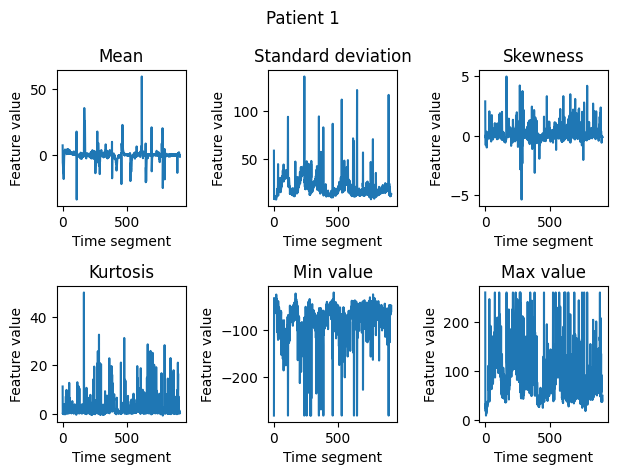

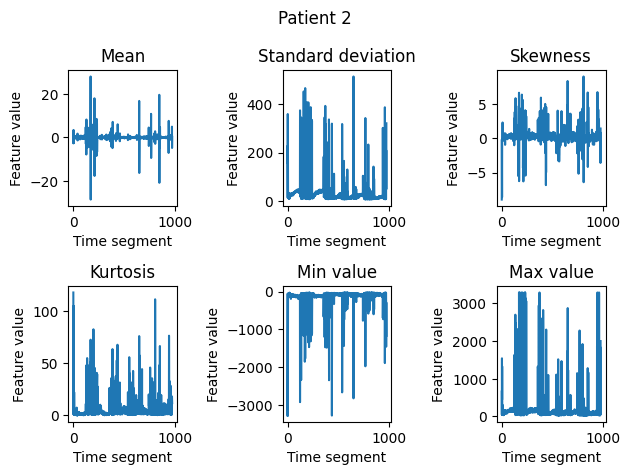

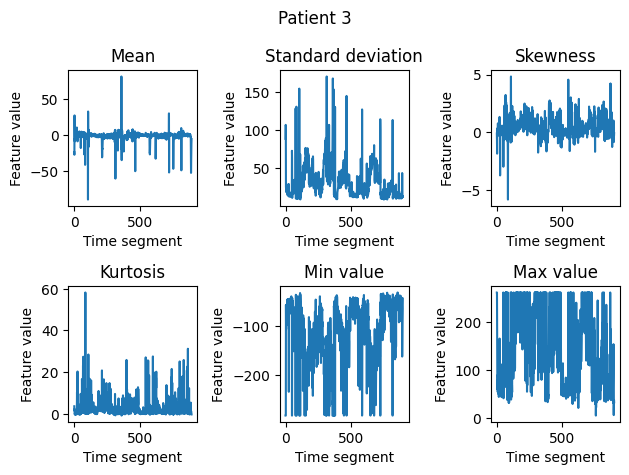

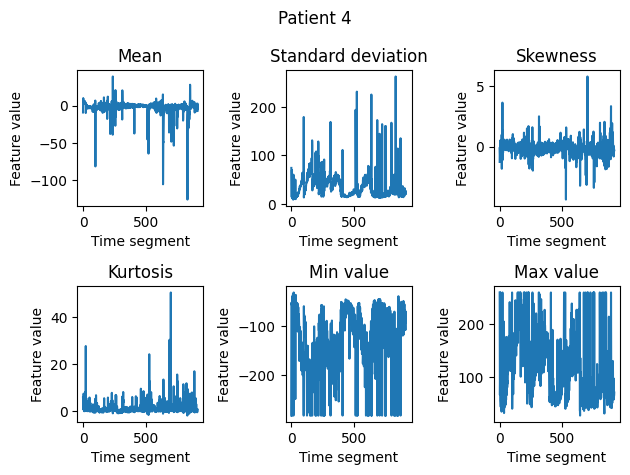

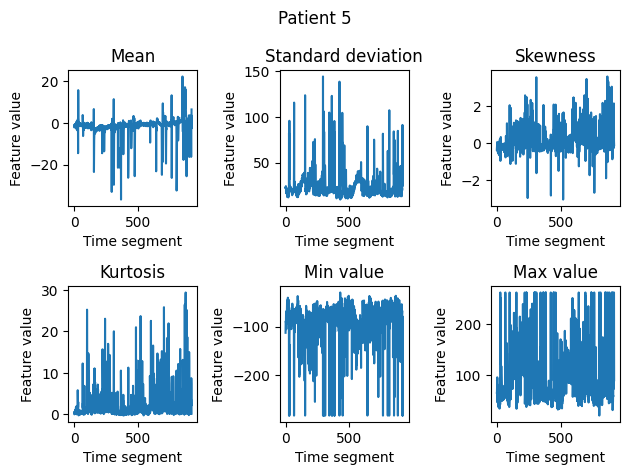

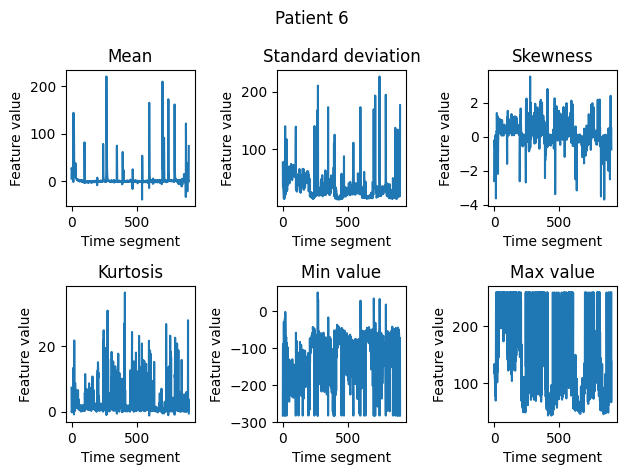

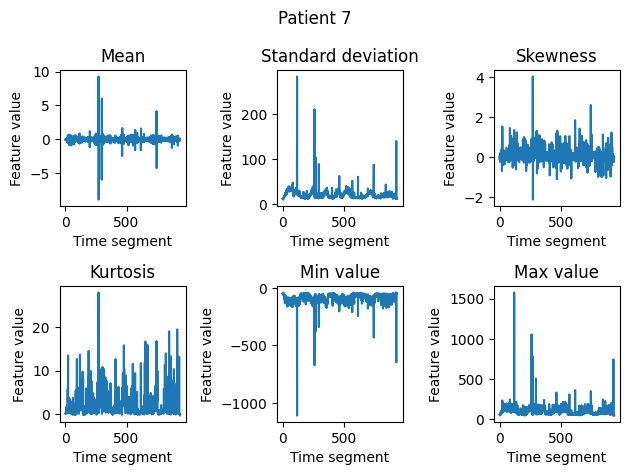

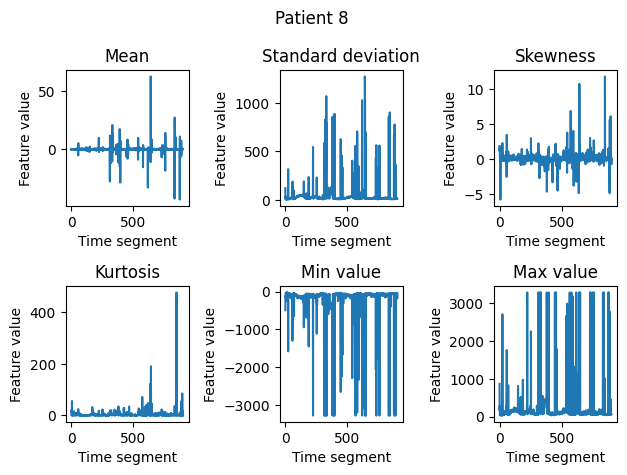

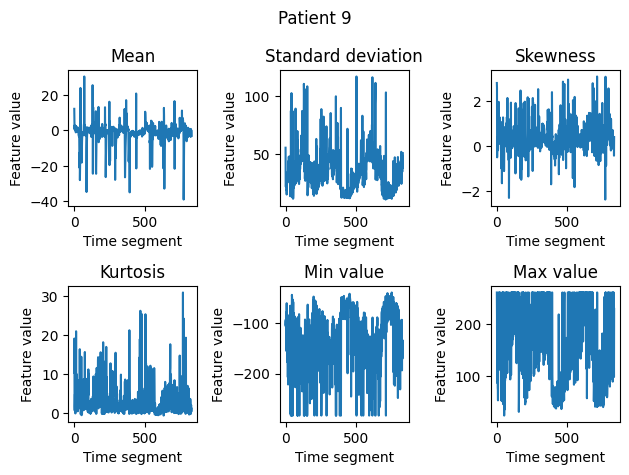

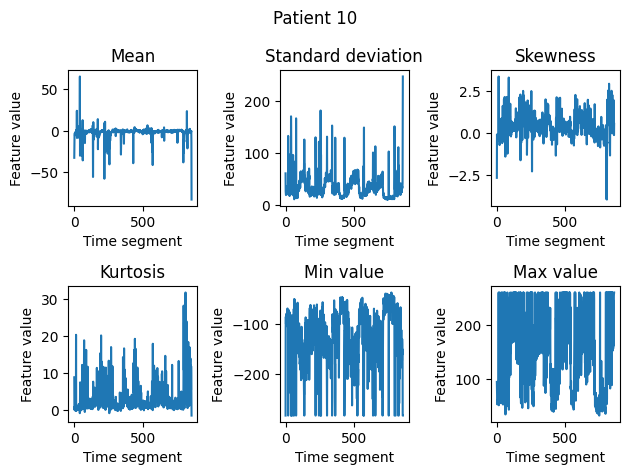

In [10]:
features_names = ["Mean", "Standard deviation", "Skewness", "Kurtosis", "Min value", "Max value"]

for i, features in enumerate(all_patients):
    plt.figure()
    for j in range(number_of_features):
        plt.subplot(2, 3, j+1)
        plt.plot(features[:, j])
        plt.title(features_names[j])
        plt.xlabel("Time segment")
        plt.ylabel("Feature value")

    plt.suptitle(f"Patient {i+1}")
    plt.tight_layout()
    plt.show()


### Vizualization of relationship between features and class

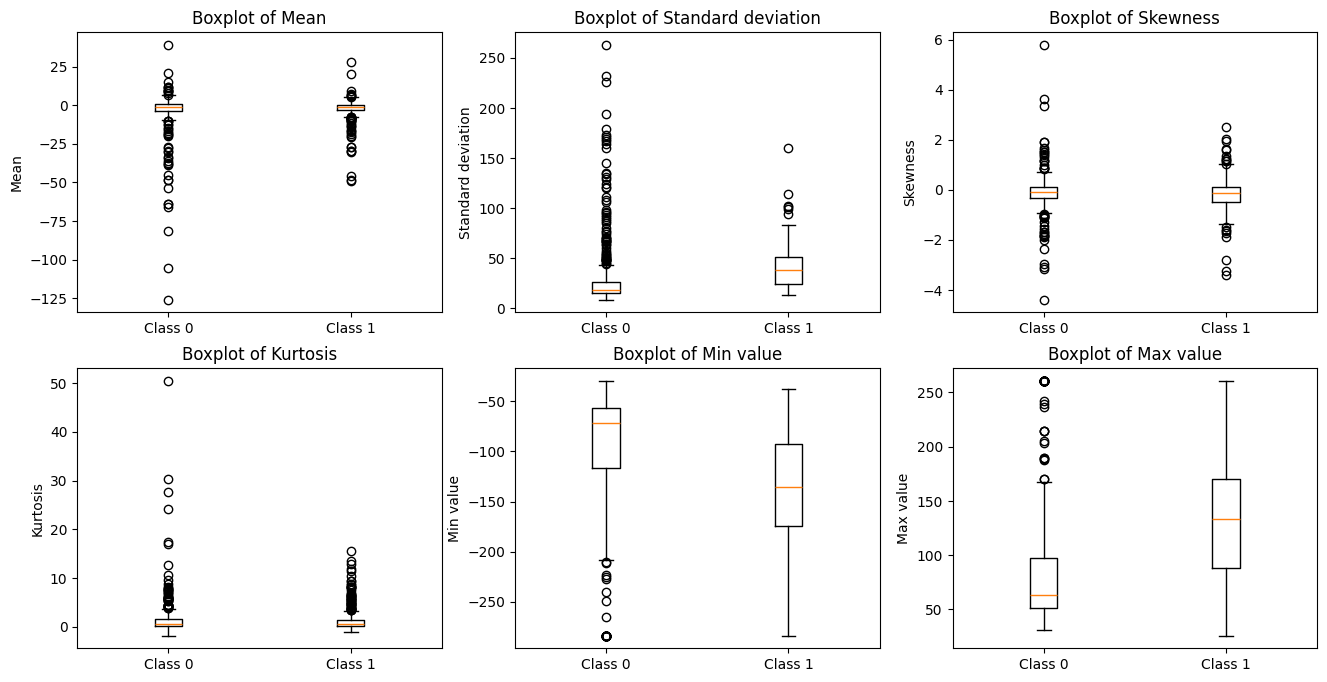

In [11]:
# I have chosen 4th patient (random choice)
features = all_patients[3]
classes = data["c04"].flatten()

_, axes = plt.subplots(2, 3, figsize=(16, 8))
for i, ax in enumerate(axes.flat):
    ax.boxplot([features[classes == 0, i], features[classes == 1, i]], tick_labels=["Class 0", "Class 1"])
    ax.set_ylabel(features_names[i])
    ax.set_title(f"Boxplot of {features_names[i]}")
plt.show()

# 4. Uloha

### Create train and test datasets

In [12]:
X_train = np.vstack(all_patients[:9])
y_train = np.concatenate([data[f"c0{i+1}"].flatten() for i in range(9)])
X_test = all_patients[9]

### Select classifiers and test accuracy
- KNN
- Random forest
- Logistic regression

In [18]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "KNN (k=2)": KNeighborsClassifier(n_neighbors=2),
    "KNN (k=3)": KNeighborsClassifier(n_neighbors=3),
    "KNN (k=4)": KNeighborsClassifier(n_neighbors=4),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "KNN (k=6)": KNeighborsClassifier(n_neighbors=6),
    "KNN (k=7)": KNeighborsClassifier(n_neighbors=7),
    "KNN (k=8)": KNeighborsClassifier(n_neighbors=8),
    "KNN (k=9)": KNeighborsClassifier(n_neighbors=9),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    print(f"{name}: Mean Accuracy = {scores.mean():.4f}, std = {scores.std():.4f}")

KNN (k=2): Mean Accuracy = 0.7051, std = 0.0036
KNN (k=3): Mean Accuracy = 0.7469, std = 0.0090
KNN (k=4): Mean Accuracy = 0.7522, std = 0.0086
KNN (k=5): Mean Accuracy = 0.7634, std = 0.0139
KNN (k=6): Mean Accuracy = 0.7649, std = 0.0112
KNN (k=7): Mean Accuracy = 0.7706, std = 0.0098
KNN (k=8): Mean Accuracy = 0.7688, std = 0.0112
KNN (k=9): Mean Accuracy = 0.7701, std = 0.0091
Random Forest: Mean Accuracy = 0.7976, std = 0.0102
Logistic Regression: Mean Accuracy = 0.6432, std = 0.0026


### Choose the best model
- KNN -> Presnost se od K=7 uz nezveda, takze podle Ocamovy britvy bychom zvolili K=7
- Nahodny les -> Presnost 0.80 je nejlepsi ze vsech testovanych klasifikatoru
- Logisticka Regrese -> Vyrazne horsi vysledky nez u ostatnich klasifikatoru (prilis jednoduchy model pro tuto ulohu)

Zvolime Nahodny Les (random forest)

In [20]:
final_model = RandomForestClassifier(random_state=42)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
print("Predicated classes for patient 10:", y_pred[:20])

Predicated classes for patient 10: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0]


In [21]:
assert len(y_pred) == 858, f"Wrong number of predictions: {len(y_pred)} (It should be 858)"

output_filename = "monika_pulcova_pokus1_randomforest.csv"
pd.DataFrame(y_pred.astype(int)).to_csv(output_filename, index=False, header=False)
